# 1. 多类分类

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib

In [2]:
data = loadmat('ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X = data["X"]
y = data["y"]

In [4]:
X.shape, y.shape

((5000, 400), (5000, 1))

In [5]:
def plot_an_image(image):
#     """
#     image : (400,)
#     """
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((20, 20)).T, cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))  # just get rid of ticks
    plt.yticks(np.array([]))

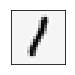

this should be [1]


In [6]:
pick_one = np.random.randint(0, 5000)
plot_an_image(X[pick_one, :])
plt.show()
print('this should be {}'.format(y[pick_one]))

In [7]:
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)).T,
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  
            #绘图函数，画100张图片

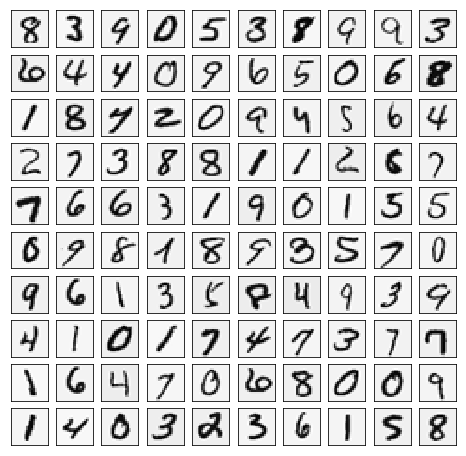

In [8]:
plot_100_image(X)
plt.show()

## sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： 
\\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## 代价函数：
$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}$

In [10]:
def cost(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / (2 * len(X))) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / len(X) + reg

如果我们要使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

以下是原始代码是使用for循环的梯度函数：

In [11]:
def gradient_with_loop(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    
    return grad

向量化的梯度函数

In [12]:
def gradient(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X * theta.T) - y
    
    grad = ((X.T * error) / len(X)).T + ((learningRate / len(X)) * theta)
    
    # intercept gradient is not regularized
    grad[0, 0] = np.sum(np.multiply(error, X[:,0])) / len(X)
    
    return np.array(grad).ravel()

In [13]:
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]
    
    # k X (n + 1) array for the parameters of each of the k classifiers
    all_theta = np.zeros((num_labels, params + 1))
    
    # insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # labels are 1-indexed instead of 0-indexed
    for i in range(1, num_labels + 1):
        theta = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))
        
        # minimize the objective function
        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradient)
        all_theta[i-1,:] = fmin.x
    
    return all_theta

In [14]:
rows = data['X'].shape[0]
params = data['X'].shape[1]

all_theta = np.zeros((10, params + 1))

X = np.insert(data['X'], 0, values=np.ones(rows), axis=1)

theta = np.zeros(params + 1)

y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((5000, 401), (5000, 1), (401,), (10, 401))

In [15]:
X = data["X"]
y = data["y"]

In [16]:
all_theta = one_vs_all(X, y, 10, 1)
all_theta

array([[-2.38358602e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30425992e-03, -7.16847809e-10,  0.00000000e+00],
       [-3.18408799e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.45914050e-03, -5.08388268e-04,  0.00000000e+00],
       [-4.79606922e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.86972388e-05, -2.47372970e-07,  0.00000000e+00],
       ...,
       [-7.98856329e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.94884414e-05,  7.21281774e-06,  0.00000000e+00],
       [-4.57180689e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33839813e-03,  1.00014717e-04,  0.00000000e+00],
       [-5.40510459e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16603979e-04,  7.88042170e-06,  0.00000000e+00]])

In [17]:
def predict_all(X, all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]
    
    # same as before, insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    
    # compute the class probability for each class on each training instance
    h = sigmoid(X * all_theta.T)
    
    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)
    
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
    return h_argmax

In [18]:
np.unique(data['y'])#看下有几类标签

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [19]:
y_pred = predict_all(data['X'], all_theta)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, data['y'])]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 94.46%


# 2. 神经网络前向传播算法

In [20]:
def load_weight(path):
    data = loadmat(path)
    return data['Theta1'], data['Theta2']

In [21]:
theta1, theta2 = load_weight('ex3weights.mat')
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [22]:
X = data["X"]
y = data["y"]
X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)  # intercept
y = y.reshape(y.shape[0])
X.shape, y.shape

((5000, 401), (5000,))

In [23]:
a1 = X

In [24]:
z2 = a1 @ theta1.T # (5000, 401) @ (25,401).T = (5000, 25)
z2.shape

(5000, 25)

In [25]:
z2 = np.insert(z2, 0, values=np.ones(z2.shape[0]), axis=1)
z2.shape

(5000, 26)

In [26]:
a2 = sigmoid(z2)
a2.shape

(5000, 26)

In [27]:
z3 = a2 @ theta2.T
z3.shape

(5000, 10)

In [29]:
a3 = sigmoid(z3)
a3.shape

(5000, 10)

In [30]:
y_pred = np.argmax(a3, axis=1) + 1  # numpy is 0 base index, +1 for matlab convention，返回沿轴axis最大值的索引，axis=1代表行
y_pred.shape

(5000,)

In [31]:
y_pred

array([10, 10, 10, ...,  9,  9,  9])

In [34]:
from sklearn.metrics import classification_report#这个包是评价报告
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          1       0.97      0.98      0.97       500
          2       0.98      0.97      0.97       500
          3       0.98      0.96      0.97       500
          4       0.97      0.97      0.97       500
          5       0.98      0.98      0.98       500
          6       0.97      0.99      0.98       500
          7       0.98      0.97      0.97       500
          8       0.98      0.98      0.98       500
          9       0.97      0.96      0.96       500
         10       0.98      0.99      0.99       500

avg / total       0.98      0.98      0.98      5000

